### Load data

In [17]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("../deep-neural-networks/notebooks/", reshape=False)

X_train, y_train = mnist.train.images, mnist.train.labels
X_validation, y_validation = mnist.validation.images, mnist.validation.labels
X_test, y_test = mnist.test.images, mnist.test.labels

assert(len(X_train) == len(y_train))
assert(len(X_validation) == len(y_validation))
assert(len(X_test) == len(y_test))

print()
print("Image Shape: {}".format(X_train[0].shape))
print()
print("Training Set:   {} samples".format(len(X_train)))
print("Validation Set: {} samples".format(len(X_validation)))
print("Test Set:       {} samples".format(len(X_test)))

Extracting ../deep-neural-networks/notebooks/train-images-idx3-ubyte.gz
Extracting ../deep-neural-networks/notebooks/train-labels-idx1-ubyte.gz
Extracting ../deep-neural-networks/notebooks/t10k-images-idx3-ubyte.gz
Extracting ../deep-neural-networks/notebooks/t10k-labels-idx1-ubyte.gz

Image Shape: (28, 28, 1)

Training Set:   55000 samples
Validation Set: 5000 samples
Test Set:       10000 samples


The MNIST data that TensorFlow pre-loads comes as 28x28x1 images.

However, the LeNet architecture only accepts 32x32xC images, where C is the number of color channels.

In order to reformat the MNIST data into a shape that LeNet will accept, we pad the data with two rows of zeros on the top and bottom, and two columns of zeros on the left and right (28+2+2 = 32).

We do not need to modify this section.

In [18]:
import numpy as np

X_train = np.pad(X_train, ((0,0), (2,2), (2,2), (0,0)), 'constant')
X_validation = np.pad(X_validation, ((0,0), (2,2), (2,2), (0,0)), 'constant')
X_test = np.pad(X_test, ((0,0), (2,2), (2,2), (0,0)), 'constant')

print("Updated image shape: {}".format(X_train[0].shape))

Updated image shape: (32, 32, 1)


### Visualize data

6


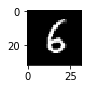

In [24]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()


plt.figure(figsize=(1,1))
plt.imshow(image, cmap="gray")
print(y_train[index])

### Preprocess data

In [25]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

### Setup TensorFlow

In [26]:
import tensorflow as tf

EPOCHS = 10
BATCH_SIZE = 128

### Implement LeNet-5

#### Input
The LeNet architecture accepts a 32x32xC image as input, where C is the number of color channels. Since MNIST images are grayscale, C is 1 in this case.

#### Architecture

__Layer 1: Convolutional.__ The output shape should be 28x28x6.

__Activation.__ Your choice of activation function.

__Pooling.__ The output shape should be 14x14x6.

__Layer 2: Convolutional.__ The output shape should be 10x10x16.

__Activation.__ Your choice of activation function.

__Pooling.__ The output shape should be 5x5x16.

__Flatten.__ Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using tf.contrib.layers.flatten, which is already imported for you.

__Layer 3: Fully Connected.__ This should have 120 outputs.

__Activation.__ Your choice of activation function.

__Layer 4: Fully Connected.__ This should have 84 outputs.

__Activation.__ Your choice of activation function.

__Layer 5: Fully Connected (Logits).__ This should have 10 outputs.

In [126]:
from tensorflow.contrib.layers import flatten

tf.reset_default_graph()

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    weights = {
        'wc1': tf.Variable(tf.truncated_normal([5, 5, 1, 6], mean=mu, stddev=sigma)),
        'wc2': tf.Variable(tf.truncated_normal([5, 5, 6, 16], mean=mu, stddev=sigma)),
        'wd1': tf.Variable(tf.truncated_normal([400, 120], mean=mu, stddev=sigma)),
        'wd2': tf.Variable(tf.truncated_normal([120, 84], mean=mu, stddev=sigma)),
        'out': tf.Variable(tf.truncated_normal([84, 10], mean=mu, stddev=sigma))        
    }
    biases = {
        'bc1': tf.Variable(tf.truncated_normal([6], mean=mu, stddev=sigma)),
        'bc2': tf.Variable(tf.truncated_normal([16], mean=mu, stddev=sigma)),
        'bd1': tf.Variable(tf.truncated_normal([120], mean=mu, stddev=sigma)),
        'bd2': tf.Variable(tf.truncated_normal([84], mean=mu, stddev=sigma)),
        'out': tf.Variable(tf.truncated_normal([10], mean=mu, stddev=sigma))
    }
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1 = tf.nn.conv2d(x, weights['wc1'], strides=[1, 1, 1, 1], padding="VALID")
    conv1 = tf.nn.bias_add(conv1, biases['bc1'])
    conv1 = tf.nn.relu(conv1)
    
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    pool1 = tf.nn.avg_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")
    
    # Layer 2: Convolutional. Output = 10x10x16.
    conv2 = tf.nn.conv2d(pool1, weights['wc2'], strides=[1, 1, 1, 1], padding="VALID")
    conv2 = tf.nn.bias_add(conv2, biases['bc2'])
    conv2 = tf.nn.relu(conv2)
    
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    pool2 = tf.nn.avg_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")

    # Flatten. Input = 5x5x16. Output = 400.
    flat = flatten(pool2)
    
    # Fully Connected. Input = 400. Output = 120.
    fc1 = tf.add(tf.matmul(flat, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2 = tf.add(tf.matmul(fc1, weights['wd2']), biases['bd2'])
    fc2 = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = 10.
    logits = tf.add(tf.matmul(fc2, weights['out']), biases['out'])
    
    return logits    

In [127]:
x = tf.placeholder(tf.float32, shape=[None, 32, 32, 1])
y = tf.placeholder(tf.int32, shape=[None])

one_hot_y = tf.one_hot(y, 10)

### Training Pipeline

In [128]:
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=rate)
training_operation = optimizer.minimize(loss_operation)

### Model Evaluation

In [129]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset + BATCH_SIZE], y_data[offset:offset + BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy*len(batch_x))
    return total_accuracy / num_examples

### Train the Model

In [130]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print('Training...')
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
    
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.958

EPOCH 2 ...
Validation Accuracy = 0.975

EPOCH 3 ...
Validation Accuracy = 0.977

EPOCH 4 ...
Validation Accuracy = 0.982

EPOCH 5 ...
Validation Accuracy = 0.987

EPOCH 6 ...
Validation Accuracy = 0.986

EPOCH 7 ...
Validation Accuracy = 0.988

EPOCH 8 ...
Validation Accuracy = 0.986

EPOCH 9 ...
Validation Accuracy = 0.985

EPOCH 10 ...
Validation Accuracy = 0.989

Model saved


### Evaluate the model

In [131]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.990
